In [1]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import pandas as pd
import scipy.signal
# from cdo import *
# cdo = Cdo()

from metpy.units import units
from scipy import stats
from scipy.stats import linregress

dir_input = '/work/mh0033/m301036/LSAT/Data/Regrid/'

data_CRUTEMP  = dir_input+'tas_CRUTEMP_regrid.nc'
data_MLOST    = dir_input+'tas_MLOST_regrid.nc'
data_GISSTEMP = dir_input+'tas_GISS_regrid.nc'

In [2]:
#Using dateTime to select key period
tas_GISS    = xr.open_dataset(data_GISSTEMP)
tas_CRUTEMP = xr.open_dataset(data_CRUTEMP) 
tas_MLOST   = xr.open_dataset(data_MLOST,decode_times=False)
units, reference_data = tas_MLOST.time.attrs['units'].split('since')
# display(tas_MLOST.time)

tas_CRUTEMP = tas_CRUTEMP.roll(lon=len(tas_CRUTEMP.lon)//2, roll_coords=True)
tas_CRUTEMP['lon'] = np.where(tas_CRUTEMP['lon']> 180, tas_CRUTEMP['lon']-360, tas_CRUTEMP['lon'])
print(tas_CRUTEMP)

tas_MLOST = tas_MLOST.roll(lon=len(tas_MLOST.lon)//2, roll_coords=True)
tas_MLOST['lon'] = np.where(tas_MLOST['lon']> 180, tas_MLOST['lon']-360, tas_MLOST['lon'])
print(tas_MLOST)

<xarray.Dataset>
Dimensions:    (time: 2078, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2023-02-15
  * lon        (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    tas        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.7
    institution:  Climatic Research Unit, University of East Anglia/Met Offic...
    comment:      CRUTEM5 air temperature at 2m
    history:      Wed May 24 15:21:38 2023: cdo remapbil,r180x90 /work/mh0033...
    licence:      CRUTEM5 is licensed under the Open Government Licence v3.0 ...
    reference:    Osborn, T. J., P. D. Jones, D. H. Lister, C. P. Morice, I. ...
    source:      

In [3]:
tas_CRUTEMP = tas_CRUTEMP.astype(np.float64)
tas_CRUTEMP = tas_CRUTEMP-273.15
# tas_GHCNv4  = tas_GHCNv4-273.15
# tas_MLOST_sel = tas_MLOST_sel-273.15
display(tas_CRUTEMP)

<xarray.Dataset>
Dimensions:    (time: 2078, lon: 180, lat: 90, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2023-02-15
  * lon        (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 -3.785e+18 -3.784e+18 ... 1.678e+18
    tas        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.7
    institution:  Climatic Research Unit, University of East Anglia/Met Offic...
    comment:      CRUTEM5 air temperature at 2m
    history:      Wed May 24 15:21:38 2023: cdo remapbil,r180x90 /work/mh0033...
    licence:      CRUTEM5 is licensed under the Open Government Licence v3.0 ...
    reference:    Osborn, T. J., P. D. Jones, D. H. Lister, C. P. Morice, I. ...
    source:       
    title:        CRUTEM5 air temperature over land
    version:      CRUTEM.5.0.1.0
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [4]:
#---------------------------------------------------------------------------
# Function to calculate the running mean
# The Savitzky-Golay filter uses convolution process applied on an array for
# smoothing. The Python package scipy provide the function as shown in the
# next example.
#---------------------------------------------------------------------------
def calc_running_mean(data, window_length=20, polyorder=3, mode='nearest'):
    return scipy.signal.savgol_filter(data,
                                      window_length,
                                      polyorder,
                                      mode='nearest')

# strip leapdays
def xr_strip_leapdays(x):

    # This function removes leap days (February 29) from a timeseries x
    # The timeseries x is assumed to have a functional "time" coordinate in the xarray style

    x_noleap = x.sel(time=~((x.time.dt.month == 2) & (x.time.dt.day == 29)))

    return(x_noleap)

In [5]:
tas_MLOST_recon = pd.to_datetime(tas_MLOST.time.data, unit='D', origin=pd.Timestamp('1800-01-01'))
tas_MLOST_recon

DatetimeIndex(['1850-01-01', '1850-02-01', '1850-03-01', '1850-04-01',
               '1850-05-01', '1850-06-01', '1850-07-01', '1850-08-01',
               '1850-09-01', '1850-10-01',
               ...
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01'],
              dtype='datetime64[ns]', length=2079, freq=None)

In [6]:
tas_MLOST = tas_MLOST.assign_coords({"time":(tas_MLOST_recon)})
tas_MLOST

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon        (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    air        (time, lat, lon) float32 -0.1569 -0.1569 -0.1418 ... 5.342 5.45
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [7]:
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=tas_MLOST['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = tas_MLOST.where(mask_data == 1, drop=False)

# Print the resulting masked dataset
masked_tas

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lat: 90, lon: 91)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon        (lon) float64 180.0 0.0 2.0 4.0 6.0 ... 172.0 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, lat, lon) float64 1.826e+04 1.826e+04 ... nan nan
    air        (time, lat, lon) float32 -0.1569 -0.1726 -0.1726 ... nan nan nan
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [9]:
tas_GISS_annual    = tas_GISS['air'].loc['1950-01-01':'2014-12-31',0:90,:]
#xr.DataArray.transpose(tas_GISS['lat'], transpose_coords=True, missing_dims='raise').groupby('time.year').groups
tas_CRUTEMP_annual = tas_CRUTEMP['tas'].loc['1950-01-01':'2014-12-31',0:90,:]
tas_MLOST_annual   = masked_tas['air'].loc['1950-01-01':'2014-12-31',0:90,:]

tas_GISS_ano     = tas_GISS_annual-tas_GISS_annual.mean()
tas_CRUTEMP_ano  = tas_CRUTEMP_annual-tas_CRUTEMP_annual.mean()
tas_MLOST_ano    = tas_MLOST_annual-tas_MLOST_annual.mean()

year = np.arange(1950,2015,1)
lat = tas_CRUTEMP['lat']
lon = tas_CRUTEMP['lon']

# print(tas_GISS_ano)
# print(tas_MLOST_ano)
print(tas_CRUTEMP_ano)

<xarray.DataArray 'tas' (time: 780, lat: 45, lon: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...

In [10]:
# tas_GISS_clima   = tas_GISS_data.groupby('time.month').mean(dim='time',skipna=True)
# tas_GISS_ano     = tas_GISS_data.groupby('time.month')-tas_GISS_clima

# tas_CRUTEMP_clima= tas_CRUTEMP_data.groupby('time.month').mean(dim='time',skipna=True)
# tas_CRUTEMP_ano  = tas_CRUTEMP_data.groupby('time.month')-tas_CRUTEMP_clima

# tas_MLOST_clima   = tas_MLOST_data.groupby('time.month').mean(dim='time',skipna=True)
# tas_MLOST_ano    = tas_MLOST_data.groupby('time.month')-tas_MLOST_clima
# # tas_GHCNv4_ano   = tas_GHCNv4_annual-tas_GHCNv4_annual.mean()

# print(tas_GISS_ano)
# print(tas_CRUTEMP_ano)
# print(tas_MLOST_ano)

In [12]:
tas_GISS_annual    = tas_GISS_ano.groupby('time.year').mean(dim='time',skipna=True)
tas_CRUTEMP_annual = tas_CRUTEMP_ano.groupby('time.year').mean(dim='time',skipna=True)
tas_MLOST_annual   = tas_MLOST_ano.groupby('time.year').mean(dim='time',skipna=True)
# tas_GHCNv4_annual  = tas_GHCNv4_ano.groupby('time.year').mean()

print(tas_GISS_annual)
print(tas_CRUTEMP_annual)
# print(tas_MLOST_annual)
# type(tas_GISS_annual)
# type(tas_CRUTEMP_annual)
# type(tas_MLOST_annual)

<xarray.DataArray 'air' (year: 65, lat: 45, lon: 180)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.609311  ,
         -0.7503996 , -0.56476307],
        [-0.67460686, -0.7057879 , -0.59844965, ..., -0.61362857,
         -0.76779646, -0.738899  ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.51308674,
         -0.5788092 ,         nan],
        [-0.37492117, -0.27169117, -0.30110037, ..., -0.50771993,
         -0.5669259 , -0.5161544 ],
...
        

In [13]:
#Test for the data correctness
tas_annual_mean_GISS = tas_GISS_annual.mean('year')
tas_annual_mean_GISS.min()

<xarray.DataArray 'air' ()>
array(-1.77091146)

In [14]:
tas_annual_mean_MLOST = tas_MLOST_annual.mean('year')
tas_annual_mean_MLOST

<xarray.DataArray 'air' (lat: 45, lon: 91)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 180.0 0.0 2.0 4.0 6.0 ... 172.0 174.0 176.0 178.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0

In [15]:
tas_annual_mean_CRUTEMP = tas_CRUTEMP_annual.mean('year')
tas_annual_mean_CRUTEMP

<xarray.DataArray 'tas' (lat: 45, lon: 180)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0

In [16]:
year = xr.DataArray(np.arange(1950,2015,1), dims='year')

In [17]:
#Calaulate the NH SAT timeseries 115-yr trend
slope = np.zeros((tas_GISS_annual.shape[1], tas_GISS_annual.shape[2]))
intercept = np.zeros((tas_GISS_annual.shape[1], tas_GISS_annual.shape[2]))
r = np.zeros((tas_GISS_annual.shape[1], tas_GISS_annual.shape[2]))
p = np.zeros((tas_GISS_annual.shape[1], tas_GISS_annual.shape[2]))
se = np.zeros((tas_GISS_annual.shape[1], tas_GISS_annual.shape[2]))
for i in np.arange(tas_GISS_annual.shape[1]):
    for j in np.arange(tas_GISS_annual.shape[2]):
        slope[i,j], intercept[i,j], r[i,j], p[i,j], se[i,j] = linregress(year, tas_GISS_annual[:,i,j])

In [18]:
print(slope.shape)

(45, 180)


In [19]:
slope1 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
intercept1 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
r1 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
p1 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
se1 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
for i in np.arange(tas_MLOST_ano.shape[1]):
    for j in np.arange(tas_MLOST_ano.shape[2]):
        slope1[i,j], intercept1[i,j], r1[i,j], p1[i,j], se1[i,j] = linregress(year, tas_MLOST_annual[:,i,j])

In [23]:
lat_CRU = tas_CRUTEMP_annual['lat']
lon_CRU = tas_CRUTEMP_annual['lon']
slope2 = np.zeros((tas_CRUTEMP_ano.shape[1], tas_CRUTEMP_ano.shape[2]))
intercept2 = np.zeros((tas_CRUTEMP_ano.shape[1], tas_CRUTEMP_ano.shape[2]))
r2 = np.zeros((tas_CRUTEMP_ano.shape[1], tas_CRUTEMP_ano.shape[2]))
p2 = np.zeros((tas_CRUTEMP_ano.shape[1], tas_CRUTEMP_ano.shape[2]))
se2 = np.zeros((tas_CRUTEMP_ano.shape[1], tas_CRUTEMP_ano.shape[2]))
for i in np.arange(tas_CRUTEMP_ano.shape[1]):
    for j in np.arange(tas_CRUTEMP_ano.shape[2]):
        slope2[i,j], intercept2[i,j], r2[i,j], p2[i,j], se2[i,j] = linregress(year, tas_CRUTEMP_annual[:,i,j])

In [24]:
lat = tas_GISS_ano['lat']
lon = tas_GISS_ano['lon']
print(lat)
print(lon)
new_dims = {'lat': lat, 'lon': lon}
slope = xr.DataArray(slope,dims=('lat','lon'), coords=new_dims)
slope.values
# type(slope)

<xarray.DataArray 'lat' (lat: 45)>
array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25., 27.,
       29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51., 53., 55.,
       57., 59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.,
       85., 87., 89.])
Coordinates:
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
<xarray.DataArray 'lon' (lon: 180)>
array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
        24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,
        48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,  70.,
        72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,
        96.,  98., 100., 102., 104., 106., 108., 110., 112., 114., 116., 118.,
       120., 122., 124., 126., 128., 130., 132., 134., 136.,

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.02264149, 0.02194712,
               nan],
       [0.01928932, 0.01717735, 0.01607447, ..., 0.02182272, 0.0218909 ,
        0.02146163],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [26]:
lat1 = tas_MLOST_ano['lat']
lon1 = tas_MLOST_ano['lon']
print(lat)
new_dims = {'lat': lat1, 'lon': lon1}
slope1 = xr.DataArray(slope1,dims=('lat','lon'), coords=new_dims)
slope1.values
# type(slope)
trend1 = slope1 * 65
print(trend1)
print(lon1)

<xarray.DataArray 'lat' (lat: 45)>
array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25., 27.,
       29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51., 53., 55.,
       57., 59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.,
       85., 87., 89.])
Coordinates:
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
<xarray.DataArray (lat: 45, lon: 91)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
  * lon      (lon) float64 180.0 0.0 2.0 4.0 6.0 ... 172.0 174.0 176.0 178.0
<xarr

In [28]:
lat2 = tas_CRUTEMP_ano['lat']
lon2 = tas_CRUTEMP_ano['lon']
print(lat2)
new_dims = {'lat': lat2, 'lon': lon2}
slope2 = xr.DataArray(slope2,dims=('lat','lon'), coords=new_dims)
slope2.values
# type(slope)

trend2 = slope2 * 65
print(trend2)
print(lon2)

<xarray.DataArray 'lat' (lat: 45)>
array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25., 27.,
       29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51., 53., 55.,
       57., 59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.,
       85., 87., 89.])
Coordinates:
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
<xarray.DataArray (lat: 45, lon: 180)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
  * lon      (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
<xarr

In [29]:
trend = slope * 65
print(trend)
print(lon)

<xarray.DataArray (lat: 45, lon: 180)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ..., 1.47169656, 1.42656252,
               nan],
       [1.2538059 , 1.11652746, 1.04484044, ..., 1.41847649, 1.42290825,
        1.39500566],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
<xarray.DataArray 'lon' (lon: 180)>
array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
        24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,
        48.,  5

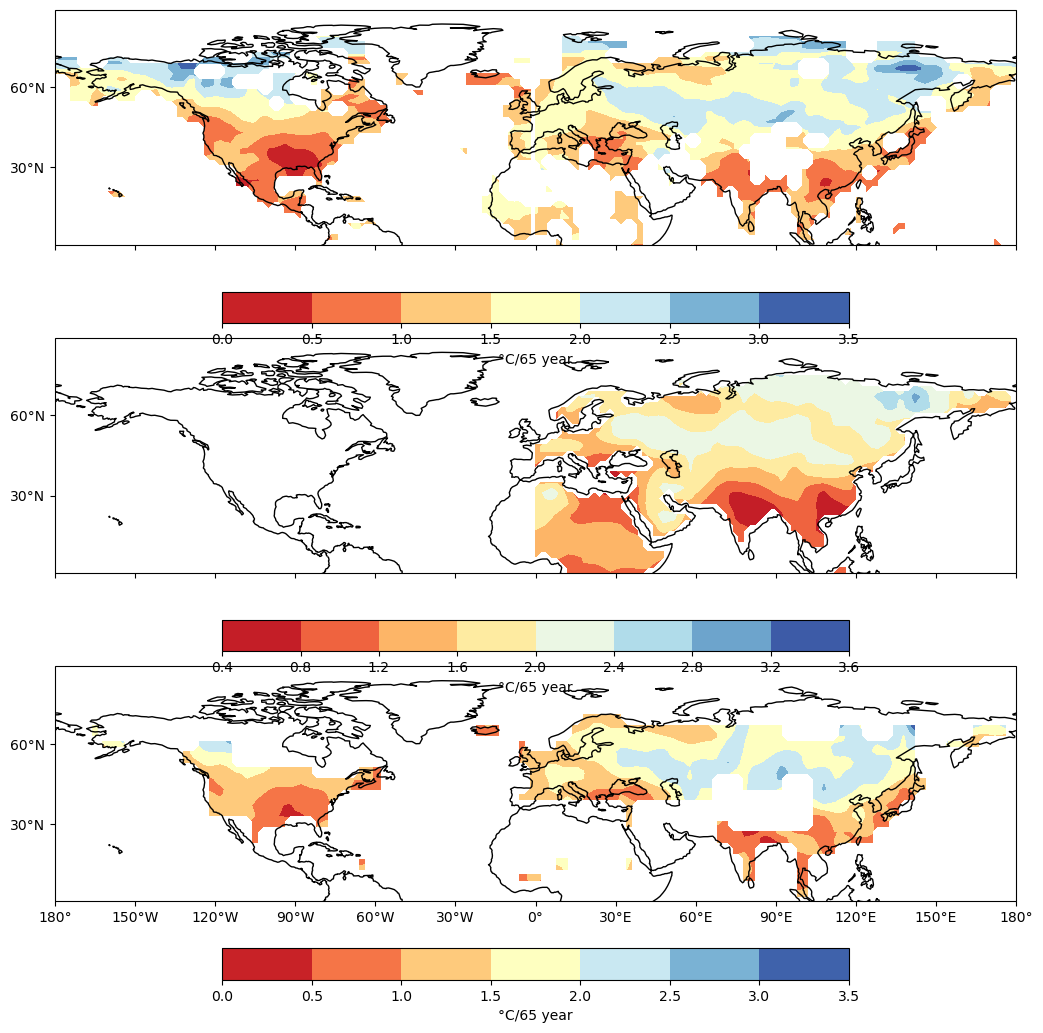

In [32]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from matplotlib.colors import BoundaryNorm, ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (12,10), sharex=True, subplot_kw={'projection': ccrs.PlateCarree()})

# Adjust the layout and spacing
plt.tight_layout()

cmap = plt.get_cmap('RdYlBu')
# boundaries = [-2.0,-1.8,-1.6,-1.4,-1.2,-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
# norm = BoundaryNorm(boundaries, cmap.N)
# Set the map projection and other properties for each subplot
for ax in [ax1, ax2, ax3]:
    ax.set_xticks(np.arange(-180, 210, 30), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 120, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    ax.coastlines()
    

c1 = ax1.contourf(lon, lat, trend, cmap=cmap,transform=ccrs.PlateCarree())
# c2 = ax1.contourf(lon, lat, p, [0,0.05,1], zorder=1, hatches=['...', None], colors='none', transfrom = ccrs.PlateCarree())
# fig.colorbar(c1,ax=ax, orientation='horizontal', fraction=.1,label='°C/115 year')
# c1 = ax.contourf(lon, lat_CRU, slope1*115,cmap ='RdYlBu', transform=ccrs.PlateCarree())
# c2 = ax.contourf(lon, lat_CRU, p1, [0,0.05,1], zorder=1, hatches=['...', None], colors='none', transfrom = ccrs.PlateCarree())
fig.colorbar(c1,ax=ax1, orientation='horizontal', fraction=0.1,label='°C/65 year')


c3 = ax2.contourf(lon1, lat1, trend1, cmap=cmap,transform=ccrs.PlateCarree())
# c4 = ax2.contourf(lon1, lat1, p1, [0,0.05,1], zorder=1, hatches=['...', None], colors='none', transfrom = ccrs.PlateCarree())
# fig.colorbar(c1,ax=ax, orientation='horizontal', fraction=.1,label='°C/65 year')
# c1 = ax.contourf(lon, lat_CRU, slope1*65,cmap ='RdYlBu', transform=ccrs.PlateCarree())
# c2 = ax.contourf(lon, lat_CRU, p1, [0,0.05,1], zorder=1, hatches=['...', None], colors='none', transfrom = ccrs.PlateCarree())
fig.colorbar(c3,ax=ax2, orientation='horizontal', fraction=0.1,label='°C/65 year')


c5 = ax3.contourf(lon2, lat2, trend2, cmap=cmap,transform=ccrs.PlateCarree())
# c6 = ax3.contourf(lon2, lat2, p2, [0,0.05,1], zorder=1, hatches=['...', None], colors='none', transfrom = ccrs.PlateCarree())
# fig.colorbar(c1,ax=ax, orientation='horizontal', fraction=.1,label='°C/65 year')
# c1 = ax.contourf(lon, lat_CRU, slope1*65,cmap ='RdYlBu', transform=ccrs.PlateCarree())
# c2 = ax.contourf(lon, lat_CRU, p1, [0,0.05,1], zorder=1, hatches=['...', None], colors='none', transfrom = ccrs.PlateCarree())
fig.colorbar(c5,ax=ax3, orientation='horizontal', fraction=0.1,label='°C/65 year')

# Create a colorbar
divider = make_axes_locatable(ax3)
# cax = divider.append_axes("bottom", size="5%", pad=0.05)

# # Create a colorbar using the contourf plot from one of the subplots
# cbar = plt.colorbar(c1, cax=cax, orientation='horizontal', ticks=boundaries)
# cbar.set_label('°C/65 year')

plt.show()